# Machine Learning: Assignment #2

Bárbara Nóbrega Galiza – 202408654​

Cláudia Oliveira - 202005668​

Marta Campos - 202008344

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Data Preprocessing

Datasets

In [66]:
# Diagnoses and their descriptions
diag = pd.read_csv('tables/DIAGNOSES_ICD.csv')
desc = pd.read_csv('tables/D_ICD_DIAGNOSES.csv')

# Patient demographic information
patients = pd.read_csv('tables/PATIENTS.csv')

# Hospital admissions 
admissions = pd.read_csv('tables/ADMISSIONS.csv')

# ICU stays per patient admission
icustays = pd.read_csv('tables/ICUSTAYS.csv')

# Charted events: vital signs, lab results, nurse observations, etc.
chartevents = pd.read_csv('tables/chart_4280.csv', low_memory=False)
#chartevents = pd.read_csv('tables/CHARTEVENTS.csv', low_memory=False)

# Dictionary that maps ITEMIDs to their names/descriptions
items = pd.read_csv('tables/D_ITEMS.csv')

inputevents = pd.read_csv('tables/INPUTEVENTS_MV.csv')

Choosing the Disease

In [30]:
d = diag[diag['ICD9_CODE'] == '4280']

diagnoses_disease = d[d['SEQ_NUM'] == 1.0].copy()

print(diagnoses_disease.size)

diag_seq2 = diag[diag['SEQ_NUM'] == 2.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity1'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity1'] = diagnoses_disease['comorbidity1'].fillna(0)

diag_seq2 = diag[diag['SEQ_NUM'] == 3.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity2'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity2'] = diagnoses_disease['comorbidity2'].fillna(0)

diagnoses_disease.head(15)

#hadm_ids = diagnoses_disease['HADM_ID'].unique()
#chart_4280 = chartevents[chartevents['HADM_ID'].isin(hadm_ids)].copy()
#chart_4280.to_csv('chart_4280.csv', index=False)

2850


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2
0,2163,176,135828,1.0,4280,42731,4251
1,2172,177,143120,1.0,4280,51881,5119
2,2460,199,185360,1.0,4280,4254,4240
3,2516,205,135671,1.0,4280,4240,5990
4,4092,351,174800,1.0,4280,78057,6110
5,3775,323,106158,1.0,4280,99672,99762
6,3784,323,128132,1.0,4280,78551,51881
7,5001,414,153627,1.0,4280,5119,42731
8,5839,495,186199,1.0,4280,5845,7895
9,7557,654,136326,1.0,4280,486,51881


Percentage of the frequency explained by the top 5 comorbities: 31.05263157894737 %


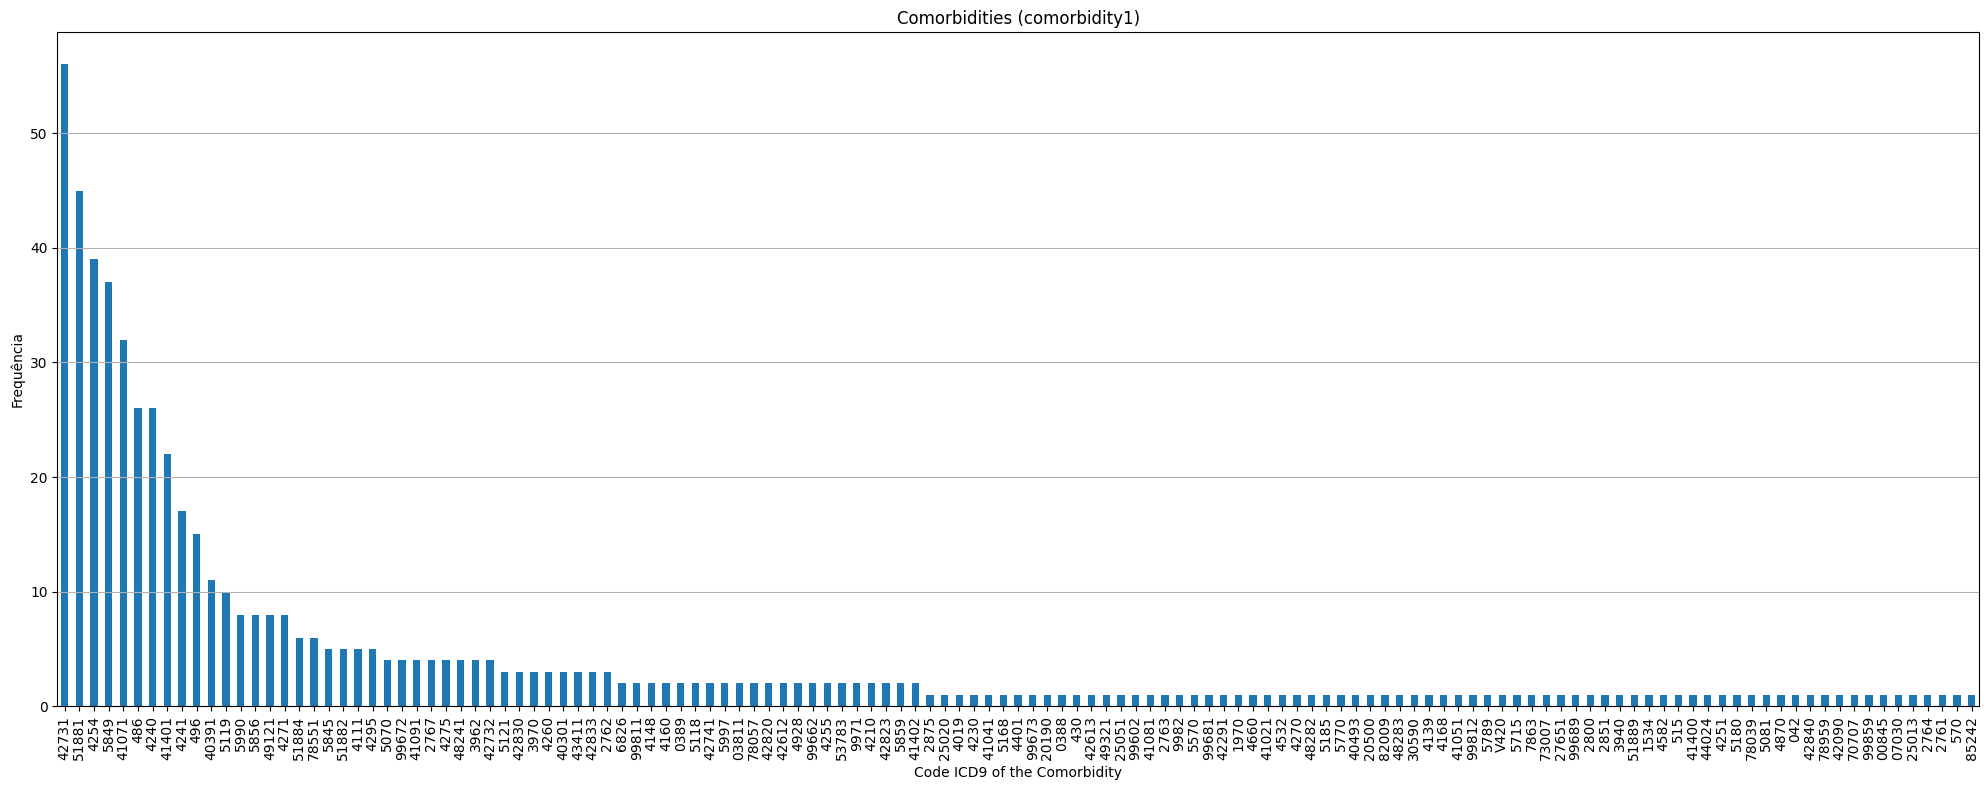

In [31]:
counts = diagnoses_disease['comorbidity1'].value_counts()

c1 = sum(counts[0:4])/sum(counts[:]) 
print("Percentage of the frequency explained by the top 5 comorbities: " + str(c1*100) + " %")

plt.figure(figsize=(20,8))
counts.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Percentage of the frequency explained by the top 5 comorbities2: 24.035087719298247 %


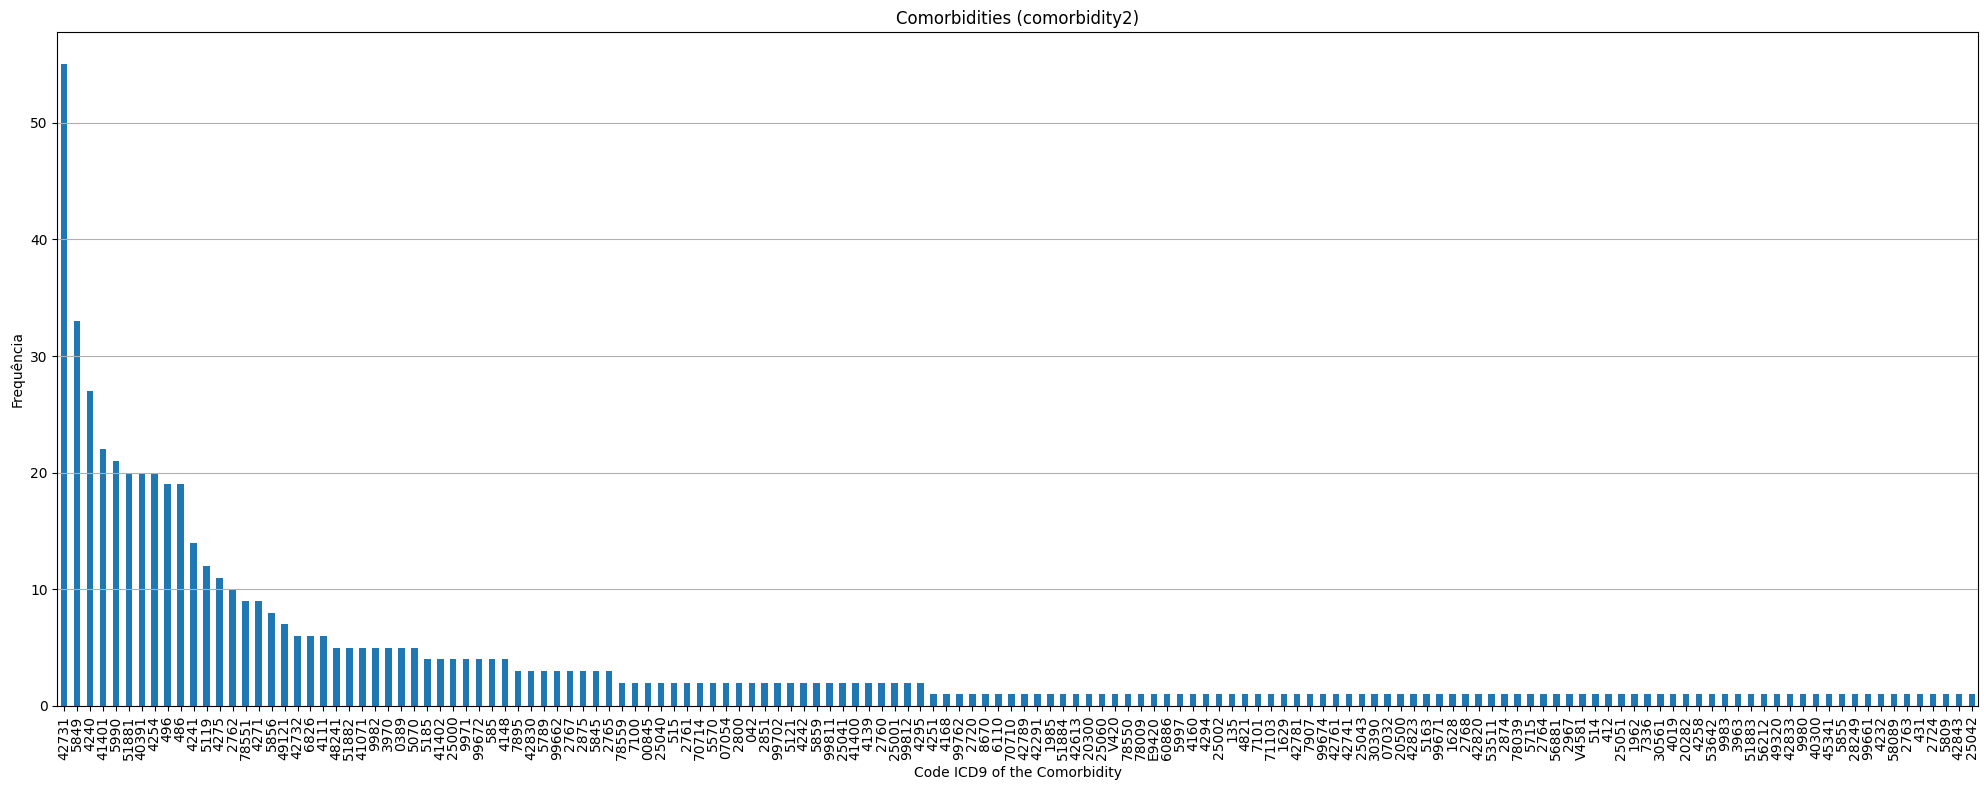

In [32]:
counts = diagnoses_disease['comorbidity2'].value_counts()

c1 = sum(counts[0:4])/sum(counts) 
print("Percentage of the frequency explained by the top 5 comorbities2: " + str(c1*100) + " %")

plt.figure(figsize=(20,8))
counts.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [33]:
print(f"Columns of Diagnosis: {diag.columns} \n")
print(f"Columns of Description of Diseases: {desc.columns} \n")
print(f"Columns of ICU Stays: {icustays.columns} \n")
print(f"Columns of Chart Events: {chartevents.columns} \n")
print(f"Columns of Patients: {patients.columns} \n")
print(f"Columns of Admissions: {admissions.columns} \n")

top_codes = diag['ICD9_CODE'].value_counts().head(15).reset_index()
top_codes.columns = ['ICD9_CODE', 'count']

top_diseases = top_codes.merge(desc[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE', how='left')

print(top_diseases)

Columns of Diagnosis: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object') 

Columns of Description of Diseases: Index(['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE'], dtype='object') 

Columns of ICU Stays: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object') 

Columns of Chart Events: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object') 

Columns of Patients: Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object') 

Columns of Admissions: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHAR

Our chosen dicease is Congestive heart failure, unspecified

ICD9_CODE 4280

### Data Preparation

In [67]:
chartevents.nunique()

ROW_ID          137698
SUBJECT_ID          82
HADM_ID             85
ICUSTAY_ID          90
ITEMID             650
CHARTTIME        11092
STORETIME        14732
CGID               370
VALUE             3495
VALUENUM          3044
VALUEUOM            65
WARNING              2
ERROR                2
RESULTSTATUS         2
STOPPED              2
dtype: int64

In [81]:
d = diag[diag['ICD9_CODE'] == '4280']
diagnoses_disease_3 = d[d['SEQ_NUM'].isin([1.0, 2.0, 3.0, 4.0, 5.0])].copy()

hadm_ids = diagnoses_disease_3['HADM_ID'].unique()
inputevents_4280 = inputevents[inputevents['HADM_ID'].isin(hadm_ids)]
inputevents_4280.nunique()

ROW_ID                           93143
SUBJECT_ID                        1091
HADM_ID                           1182
ICUSTAY_ID                        1206
STARTTIME                        48470
ENDTIME                          56108
ITEMID                             173
AMOUNT                           41408
AMOUNTUOM                            9
RATE                             28495
RATEUOM                             13
STORETIME                        43225
CGID                               400
ORDERID                          63054
LINKORDERID                      47582
ORDERCATEGORYNAME                   16
SECONDARYORDERCATEGORYNAME           4
ORDERCOMPONENTTYPEDESCRIPTION        3
ORDERCATEGORYDESCRIPTION             5
PATIENTWEIGHT                      568
TOTALAMOUNT                        319
TOTALAMOUNTUOM                       1
ISOPENBAG                            2
CONTINUEINNEXTDEPT                   2
CANCELREASON                         3
STATUSDESCRIPTION        

In [69]:
inputevents.nunique()

ROW_ID                           3618991
SUBJECT_ID                         17680
HADM_ID                            21879
ICUSTAY_ID                         23386
STARTTIME                        1682649
ENDTIME                          2033053
ITEMID                               278
AMOUNT                           1299808
AMOUNTUOM                             16
RATE                              848060
RATEUOM                               16
STORETIME                        1510880
CGID                                 504
ORDERID                          2450079
LINKORDERID                      1872309
ORDERCATEGORYNAME                     16
SECONDARYORDERCATEGORYNAME             4
ORDERCOMPONENTTYPEDESCRIPTION          3
ORDERCATEGORYDESCRIPTION               5
PATIENTWEIGHT                       1362
TOTALAMOUNT                         2526
TOTALAMOUNTUOM                         1
ISOPENBAG                              2
CONTINUEINNEXTDEPT                     2
CANCELREASON    

In [ ]:
""" # Merge com a tabela de ADMISSIONS para adicionar informações da internação (ADMITTIME, ADMISSION_TYPE, etc.)
dataset = d1.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Merge com a tabela de PATIENTS para adicionar as informações demográficas (GENDER, DOB)
dataset = dataset.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')

# Merge com a tabela de CHARTEVENTS para adicionar os dados dos sinais vitais, exames laboratoriais, etc.
dataset = dataset.merge(chartevents[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Merge com a tabela de ICUSTAYS para adicionar os dados de LOS (Length of Stay) por ICUSTAY_ID
dataset = dataset.merge(icustays[['ICUSTAY_ID', 'LOS']], on='ICUSTAY_ID', how='left')

# Exibindo as primeiras linhas para verificar se o merge foi bem sucedido
print(dataset.head(5)) """

dataset = icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS']]

print(len(dataset))

dataset = dataset.merge(admissions[['HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']], on=['HADM_ID'], how='left')

print(len(dataset))

dataset = dataset.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')

print(len(dataset))

dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1", "comorbidity2"]], on="HADM_ID", how="left")

print(len(dataset))

dataset = dataset.merge(chartevents[['ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM']], on=['ICUSTAY_ID'], how='left')

print(len(dataset))


dataset.columns


61532
61532
61532
61532
199140


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DOB', 'comorbidity1',
       'comorbidity2', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM'],
      dtype='object')

In [55]:
dataset['ICUSTAY_ID'].value_counts()
dataset.head(10)

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,DOB,comorbidity1,comorbidity2,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM
0,280836,268,110404,3.2490,2198-02-11 13:40:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,SEPARATED,HISPANIC OR LATINO,F,2132-02-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,206613,269,106296,3.2788,2170-11-05 11:04:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,UNOBTAINABLE,SINGLE,WHITE,M,2130-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,220345,270,188028,2.8939,2128-06-23 18:26:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,JEHOVAH'S WITNESS,MARRIED,UNKNOWN/NOT SPECIFIED,M,2048-05-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,249196,271,173727,2.0600,2120-08-07 18:56:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,NOT SPECIFIED,MARRIED,PATIENT DECLINED TO ANSWER,F,2074-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210407,272,164716,1.6202,2186-12-25 21:06:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,UNOBTAINABLE,MARRIED,WHITE,M,2119-11-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,241507,273,158689,1.4862,2141-04-19 06:11:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,M,2107-08-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,254851,274,130546,8.8143,2114-06-28 22:16:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,M,2048-05-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,219649,275,129886,7.1314,2170-10-06 03:09:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,NOT SPECIFIED,MARRIED,WHITE,M,2088-08-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,206327,276,135156,1.3378,2147-11-19 16:53:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,UNOBTAINABLE,SINGLE,WHITE,M,2112-01-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,272866,277,171601,0.7313,2132-10-21 21:09:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Medicaid,UNOBTAINABLE,NaN,BLACK/AFRICAN AMERICAN,M,2132-10-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# 1. Converte 'ADMITTIME' e 'DOB' para datetime (com erros forçados como NaT)
dataset['ADMITTIME'] = pd.to_datetime(dataset['ADMITTIME'], errors='coerce')
dataset['DOB'] = pd.to_datetime(dataset['DOB'], errors='coerce')

dataset['AGE'] = None

def safe_calculate_age(row):
    try:
        if pd.isna(row['ADMITTIME']) or pd.isna(row['DOB']):
            return None
        if row['DOB'].year > 2200:
            return 89
        age = (row['ADMITTIME'] - row['DOB']).days / 365.242
        return 89 if age > 89 else age
    except Exception as e:
        return None

dataset['AGE'] = dataset.apply(safe_calculate_age, axis=1)

dataset['AGE'] = dataset['AGE'].fillna(200).astype(int)
dataset = dataset[dataset['AGE'] != 200]

# 5. (opcional) dropa as colunas DOB e ADMITTIME
dataset.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

# Verifica
print(dataset[['SUBJECT_ID', 'AGE']].head())

   SUBJECT_ID  AGE
0         268   65
1         269   40
2         270   80
3         271   45
4         272   67


In [56]:
print(len(dataset))
dataset.isna().sum()

199140


ICUSTAY_ID                 0
SUBJECT_ID                 0
HADM_ID                    0
LOS                       10
ADMITTIME                  0
ADMISSION_TYPE             0
ADMISSION_LOCATION         0
INSURANCE                  0
RELIGION                1642
MARITAL_STATUS         14107
ETHNICITY                  0
GENDER                     0
DOB                        0
comorbidity1           60991
comorbidity2           60991
ITEMID                 61442
CHARTTIME              61442
VALUE                  65088
VALUENUM              104005
VALUEUOM              112274
dtype: int64

In [61]:
print(icustays.nunique())
print(len(icustays))
dataset.nunique()

ROW_ID            61532
SUBJECT_ID        46476
HADM_ID           57786
ICUSTAY_ID        61532
DBSOURCE              3
FIRST_CAREUNIT        6
LAST_CAREUNIT         6
FIRST_WARDID         16
LAST_WARDID          17
INTIME            61531
OUTTIME           61518
LOS               40175
dtype: int64
61532


ICUSTAY_ID            61532
SUBJECT_ID            46476
HADM_ID               57786
LOS                   40175
ADMITTIME             57500
ADMISSION_TYPE            4
ADMISSION_LOCATION        9
INSURANCE                 5
RELIGION                 20
MARITAL_STATUS            7
ETHNICITY                41
GENDER                    2
DOB                   32523
comorbidity1            128
comorbidity2            148
ITEMID                  650
CHARTTIME             11092
VALUE                  3495
VALUENUM               3044
VALUEUOM                 65
LABEL                   604
dtype: int64

In [ ]:
dataset.SUBJECT_ID.nunique()

46476

In [12]:
print(pd.unique(dataset.ITEMID.dropna().astype(int)))
dataset.ITEMID.nunique()

[   211    212    324    425    428    432    456    467    470    478
    550    593    599    617    618    621    637    644    646    660
    663    707    742   1125   1337   1425   1484   1703    161    723
   1044   1046    187    525     45     47   1622   1623    674    677
    678     27     80     82     83     84     85     86     87     88
    154    454    479    527    547    582    680    704   1087    159
    781    784    786    787    788    791    796    797    798    799
    800    811    813    814     69    762    916    917    919    920
    924    925    926    927    930    935     31     32     54     77
    165    166    167    168    169    170    171    172    184    198
    210    522    524    815    824    825    827    828    829    833
    837    861   1127   1162   1286   1522   1523   1525   1529   1530
   1533   1534   1535   1536   1542    128    130    137    158    197
    207    208    230    232    244    283    340    346    358    364
    37

650

In [58]:
dataset = dataset.merge(items[["LABEL", "ITEMID"]], on="ITEMID", how="left")

In [ ]:
#dataset[['LABEL', 'ITEMID', 'VALUE', 'SUBJECT_ID']].to_csv('items_processed.csv', index=False)

In [59]:
dataset['LABEL'] = dataset['LABEL'].str.lower()
print(len(dataset[dataset['LABEL'] == "heart rate"]))
print(dataset[dataset['LABEL'] == "heart rate"]["ICUSTAY_ID"].nunique())
result = dataset[dataset['LABEL'] == "heart rate"].groupby('SUBJECT_ID')['ITEMID'].unique()
result

6764
70


SUBJECT_ID
176         [211.0]
177         [211.0]
199         [211.0]
205         [211.0]
323         [211.0]
            ...    
95325    [220045.0]
96094    [220045.0]
97649    [220045.0]
98182    [220045.0]
99067    [220045.0]
Name: ITEMID, Length: 65, dtype: object

In [63]:
label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)
sum(label_counts["count"])

          LABEL  count
226  hemoglobin     89
89          bun     83
598         wbc     83
133  creatinine     83
269         inr     79
..          ...    ...
3       abi (r)      1
2       abi (l)      1
0         aado2      1
602      zzo2av      1
603     zzo2avi      1

[604 rows x 2 columns]


8315

Preprocessing Items table. Needed because a lot of the same items are duplicated with different ITEMIDs. Example: heart rate

In [17]:
print(items[items['ITEMID'] == 211].LABEL)
print(items[items['ITEMID'] == 220045].LABEL)

print("\n")

print(len(items))
items['LABEL'].nunique()

475    Heart Rate
Name: LABEL, dtype: object
11498    Heart Rate
Name: LABEL, dtype: object


12487


11846

In [ ]:
items['LABEL'] = items['LABEL'].str.lower()
items['LABEL'].nunique()
#items.to_csv('items_processed.csv', index=False)

In [ ]:
vitals_labs = ['heart rate', 'systolic bp', 'diastolic bp', 'respiratory rate', 'SpO2', 'BNP', 'Creatinine', 'Sodium']

### Training and Validation

### Analysis of Results and Interpretation